# Cleaning the Data

41.8755616,-87.6244212 lat,long

## 1 Create our environment

#### Create the Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

In [3]:
sc_conf = SparkConf()

In [4]:
sc_conf.set('spark.driver.port', '62678')
sc_conf.set('spark.rdd.compress', 'True')
sc_conf.set('spark.driver.host', '127.0.0.1')
sc_conf.set('spark.serializer.objectStreamReset', '100')
sc_conf.set('spark.master', 'local[*]')
sc_conf.set('spark.executor.id', 'driver')
sc_conf.set('spark.submit.deployMode', 'client')
sc_conf.set('spark.ui.showConsoleProgress', 'true')
sc_conf.set('spark.app.name', 'pyspark-shell')
sc_conf.set("spark.executor.memory","1g")
sc_conf.set("spark.driver.memory","6g")

In [5]:
sc_conf.getAll()

dict_items([('spark.driver.port', '62678'), ('spark.rdd.compress', 'True'), ('spark.driver.host', '127.0.0.1'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell'), ('spark.executor.memory', '1g'), ('spark.driver.memory', '6g')])

In [6]:
sc = SparkContext(conf=sc_conf)

In [7]:
sql = SQLContext(sc)

In [8]:
session = sql.sparkSession
session

In [9]:
session.sparkContext.getConf().getAll()

[('spark.driver.port', '62679'),
 ('spark.driver.host', '127.0.0.1'),
 ('spark.driver.memory', '6g'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.id', 'local-1554561986358')]

#### Load the libraries, we´re going to use 

In [10]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import seaborn as sns
from tqdm import tqdm_notebook
pd.options.display.max_columns = None

#### Read the data

In [53]:
taxi_df = session.read.csv('Data/Taxi_Trips.csv',
                              header=True,
                              inferSchema=True)
taxi_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+---------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|Community Areas|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------

In [54]:
taxi_df = taxi_df.sample(0.004)

## 2 Quick data analysis 

#### Get some trips to check the data

In [14]:
taxi_obs=taxi_df.limit(5)
taxi_obs.toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,2014bdb2508757f9fd8b5cd1a33cf24e67a421d8,296cddcb1099b802d5ed3f470e180bd12feb786b93dd9f...,05/23/2016 10:30:00 AM,05/23/2016 11:15:00 AM,2700,18.4,1.703198e+10,1.703184e+10,76,32,44.50,12.12,0.0,4.0,61.12,Credit Card,None,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),75
1,2014dbbd8537e4cd805eedf4d90535014f99caf8,e3cc7912da1547a0c5970e1d365c985a29523406e5ea47...,03/17/2016 01:45:00 PM,03/17/2016 02:00:00 PM,720,2.0,1.703184e+10,1.703133e+10,32,33,9.50,2.00,0.0,0.0,11.50,Credit Card,Top Cab Affiliation,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),38
2,2014dc31431cedbaee280d47329d27896fea0102,d461dc72b7a599bfba3f33fae867f5530e0c5aa5c200d8...,09/01/2015 07:15:00 AM,09/01/2015 07:30:00 AM,300,0.0,1.703108e+10,1.703128e+10,8,28,5.85,1.00,0.0,0.0,6.85,Credit Card,Taxi Affiliation Services,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),37
3,2014ee275cdabe4bca02007aa25ab617701054a2,d8238dd38b47fc0268e0bd92bba094676752dfefeafea9...,01/05/2013 01:30:00 AM,01/05/2013 01:45:00 AM,480,2.2,NaN,NaN,8,28,7.85,0.00,0.0,0.0,7.85,Cash,Dispatch Taxi Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),37
4,2014fcebeef117fe030ad568347f34bcc33a8466,d2ec583d8a9dc229ced98812a8f7645bfc2588dfbd4192...,04/01/2016 02:15:00 PM,04/01/2016 02:15:00 PM,300,0.0,1.703128e+10,1.703128e+10,28,28,5.50,4.00,0.0,0.0,9.50,Credit Card,Taxi Affiliation Services,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.879255,-87.642649,POINT (-87.642648998 41.8792550844),29


The following columns can be deleted because they do not add value as a result of which they are unions or repetitions of other columns:

    - Pickup Census Tract	
    - Dropoff Census Tract
    - Pickup Centroid Location
    - Dropoff Centroid Location
    - Community Areas


#### Study the dimensions of the dataset

In [15]:
taxi_df.count()

451682

In [16]:
len(taxi_df.columns)

24

#### Check the names and types of the variables

In [55]:
taxi_df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

## 3 Data Wrangling

### Change the name of the variables to comply with good practices

In [56]:
for col in taxi_df.columns:
    new_col=col.lower().replace(" ","_")
    taxi_df = taxi_df.withColumnRenamed(col,new_col)
taxi_df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_

### Delete fields that do not add value

In [26]:
#The following columns can be deleted because they do not add value as a result of which they are unions or 
#repetitions of other columns
taxi_df = taxi_df.drop('pickup_census_tract',
                       'dropoff_census_tract',
                       'pickup_centroid_location',
                       'dropoff_centroid__location',
                       'community_areas')

In [29]:
taxi_df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_longitude: double (nullable = true)



### Manage the dates

#### Convert the dates from string format to date format

In [19]:
# Check the start trip and the end trip before change the format
taxi_df.select(['trip_start_timestamp', 'trip_end_timestamp']).show(truncate=False)

+----------------------+----------------------+
|trip_start_timestamp  |trip_end_timestamp    |
+----------------------+----------------------+
|05/23/2016 10:30:00 AM|05/23/2016 11:15:00 AM|
|03/17/2016 01:45:00 PM|03/17/2016 02:00:00 PM|
|09/01/2015 07:15:00 AM|09/01/2015 07:30:00 AM|
|01/05/2013 01:30:00 AM|01/05/2013 01:45:00 AM|
|04/01/2016 02:15:00 PM|04/01/2016 02:15:00 PM|
|11/15/2015 10:15:00 PM|11/15/2015 10:30:00 PM|
|03/14/2013 10:15:00 AM|03/14/2013 10:30:00 AM|
|10/19/2013 11:30:00 PM|10/19/2013 11:30:00 PM|
|05/31/2017 01:00:00 PM|05/31/2017 01:00:00 PM|
|05/27/2014 11:00:00 AM|05/27/2014 11:00:00 AM|
|09/25/2014 01:45:00 PM|09/25/2014 02:00:00 PM|
|11/16/2015 01:00:00 AM|11/16/2015 01:00:00 AM|
|11/19/2014 03:15:00 PM|11/19/2014 03:30:00 PM|
|02/09/2014 01:15:00 AM|02/09/2014 01:30:00 AM|
|04/29/2016 01:00:00 PM|04/29/2016 01:00:00 PM|
|01/30/2015 09:30:00 PM|01/30/2015 09:45:00 PM|
|03/21/2013 09:45:00 PM|03/21/2013 10:00:00 PM|
|04/11/2013 11:45:00 AM|04/11/2013 12:00

In [20]:
#Convert to date format ()
taxi_df = taxi_df.withColumn("trip_start_timestamp",
                             F.from_unixtime(F.unix_timestamp(F.col("trip_start_timestamp"),
                                                           format="MM/dd/yyyy hh:mm:ss aa")))
taxi_df = taxi_df.withColumn("trip_end_timestamp",
                             F.from_unixtime(F.unix_timestamp(F.col("trip_end_timestamp"),
                                                           format="MM/dd/yyyy hh:mm:ss aa")))

In [21]:
#Check the result
taxi_df.select(['trip_start_timestamp', 'trip_end_timestamp']).show(truncate=False)

+--------------------+-------------------+
|trip_start_timestamp|trip_end_timestamp |
+--------------------+-------------------+
|2016-05-23 10:30:00 |2016-05-23 11:15:00|
|2016-03-17 13:45:00 |2016-03-17 14:00:00|
|2015-09-01 07:15:00 |2015-09-01 07:30:00|
|2013-01-05 01:30:00 |2013-01-05 01:45:00|
|2016-04-01 14:15:00 |2016-04-01 14:15:00|
|2015-11-15 22:15:00 |2015-11-15 22:30:00|
|2013-03-14 10:15:00 |2013-03-14 10:30:00|
|2013-10-19 23:30:00 |2013-10-19 23:30:00|
|2017-05-31 13:00:00 |2017-05-31 13:00:00|
|2014-05-27 11:00:00 |2014-05-27 11:00:00|
|2014-09-25 13:45:00 |2014-09-25 14:00:00|
|2015-11-16 01:00:00 |2015-11-16 01:00:00|
|2014-11-19 15:15:00 |2014-11-19 15:30:00|
|2014-02-09 01:15:00 |2014-02-09 01:30:00|
|2016-04-29 13:00:00 |2016-04-29 13:00:00|
|2015-01-30 21:30:00 |2015-01-30 21:45:00|
|2013-03-21 21:45:00 |2013-03-21 22:00:00|
|2013-04-11 11:45:00 |2013-04-11 12:00:00|
|2014-04-13 00:15:00 |2014-04-13 00:15:00|
|2015-09-03 00:15:00 |2015-09-03 00:30:00|
+----------

#### Check the extreme values of the dates

In [22]:
taxi_df.select(F.max('trip_start_timestamp'),F.min('trip_start_timestamp')).show()

+-------------------------+-------------------------+
|max(trip_start_timestamp)|min(trip_start_timestamp)|
+-------------------------+-------------------------+
|      2017-07-31 23:45:00|      2013-01-01 00:00:00|
+-------------------------+-------------------------+



In [23]:
taxi_df.select(F.max('trip_end_timestamp'),F.min('trip_end_timestamp')).show()

+-----------------------+-----------------------+
|max(trip_end_timestamp)|min(trip_end_timestamp)|
+-----------------------+-----------------------+
|    2017-08-01 00:00:00|    2013-01-01 00:15:00|
+-----------------------+-----------------------+



### Check duplicates

In [25]:
taxi_df.dropDuplicates(['trip_id', 'taxi_id']).count()

451682

There is not duplicates

### Study if there are variables that always or practically always have the same value

Separate the dataframe in two to realize our analysis:
    
    - One dataframe with numeric columns
    - One dataframe with categorical columns

In [65]:
n_rows = taxi_df.count()
numeric_vars = []
categoric_vars = []

for col, tipo in taxi_df.dtypes:
    if tipo!="string":
        numeric_vars.append(col)
    else:
        categoric_vars.append(col)     

In [66]:
categoric_vars

['trip_id',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'payment_type',
 'company',
 'pickup_centroid_location',
 'dropoff_centroid__location']

In [67]:
numeric_vars

['trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'community_areas']

In [32]:
# We delete trip_id from our analysis because it is the only value that allows us to identify travel and we know it´s
# an unique value (it has not duplicates)
categoric_vars.remove('trip_id')

#### Categoric columns

In [33]:
for col in categoric_vars:
    print(col)
    taxi_df.groupby(col).count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                  F.round((100*F.col("count")/n_rows),2)).show()

taxi_id
+--------------------+-----+-------------+
|             taxi_id|count|frecuencia(%)|
+--------------------+-----+-------------+
|f68eb3233f3e33e98...|  248|         0.05|
|d3a5f1452b4a1db2a...|  235|         0.05|
|89bfd3f9c1a6014be...|  231|         0.05|
|aebf720288b80a8ee...|  224|         0.05|
|774c16d2c0c72290e...|  223|         0.05|
|4f189764b8d9b6f71...|  218|         0.05|
|842e2b1cd011fab01...|  216|         0.05|
|53f28dea0e1172c28...|  214|         0.05|
|b2a007b1410c7208a...|  213|         0.05|
|9eb860ce5cb7ff8e3...|  212|         0.05|
|a21e9e59e7c6a55f3...|  212|         0.05|
|ef7488a67b3bdf0ea...|  211|         0.05|
|1158f25979ad78fd3...|  210|         0.05|
|fc861e3e571512d61...|  208|         0.05|
|61abb47c5869d156b...|  206|         0.05|
|ffc2a618ad19a63fa...|  205|         0.05|
|4f1e94982e6851725...|  204|         0.05|
|e1aff5afebc38449d...|  204|         0.05|
|5ba3a19b228cd79e8...|  203|         0.04|
|567c4d46516a4e135...|  202|         0.04|
+--

We have observed that in the column 'payment_type' there is the value 'Unknown', so we are going to convert it to null

In [36]:
taxi_df = taxi_df.withColumn('payment_type',
                            F.when(F.col('payment_type')=='Unknown',None).otherwise(F.col('payment_type')))

In [37]:
#Check that 'Unknown' value has been converted to null
print('payment_type')
taxi_df.groupby('payment_type').count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                                                                    F.round((100*F.col("count")/n_rows),2)).show()

payment_type
+------------+------+-------------+
|payment_type| count|frecuencia(%)|
+------------+------+-------------+
|        Cash|271520|        60.11|
| Credit Card|175917|        38.95|
|   No Charge|  2859|         0.63|
|        null|   970|         0.21|
|     Dispute|   257|         0.06|
|       Pcard|   106|         0.02|
|      Prcard|    53|         0.01|
+------------+------+-------------+



#### Numeric columns

In [34]:
for col in numeric_vars:
    print(col)
    taxi_df.groupby(col).count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                  F.round((100*F.col("count")/n_rows),2)).show()

trip_seconds
+------------+-----+-------------+
|trip_seconds|count|frecuencia(%)|
+------------+-----+-------------+
|           0|36813|         8.15|
|         360|30918|         6.85|
|         420|30045|         6.65|
|         300|28922|          6.4|
|         480|28293|         6.26|
|         540|25920|         5.74|
|         240|24385|          5.4|
|         600|23106|         5.12|
|         660|20522|         4.54|
|         720|17669|         3.91|
|         180|16783|         3.72|
|         780|15243|         3.37|
|         840|13059|         2.89|
|         900|11063|         2.45|
|         960| 9412|         2.08|
|         120| 8651|         1.92|
|        1020| 8196|         1.81|
|        1080| 7027|         1.56|
|        1140| 6365|         1.41|
|          60| 5694|         1.26|
+------------+-----+-------------+
only showing top 20 rows

trip_miles
+----------+------+-------------+
|trip_miles| count|frecuencia(%)|
+----------+------+-------------+
|       

+-------------------------+-----+-------------+
|pickup_centroid_longitude|count|frecuencia(%)|
+-------------------------+-----+-------------+
|                     null|67007|        14.83|
|            -87.632746489|40028|         8.86|
|            -87.620992913|23332|         5.17|
|            -87.633308037|18875|         4.18|
|            -87.626214906|17960|         3.98|
|             -87.63186395|16265|          3.6|
|            -87.903039661|16211|         3.59|
|            -87.655998182|14421|         3.19|
|            -87.642648998|13098|          2.9|
|            -87.618868355|10792|         2.39|
|            -87.625192142|10175|         2.25|
|             -87.63784421| 9893|         2.19|
|            -87.626210532| 9429|         2.09|
|            -87.649488729| 8850|         1.96|
|            -87.628874157| 7899|         1.75|
|            -87.642808466| 7840|         1.74|
|            -87.676355989| 7570|         1.68|
|            -87.621971652| 7479|       

### Study the null values 

In [38]:
nulos = {}
for column in taxi_df.columns:
    n_nulls = taxi_df.filter(F.col(column).isNull()).count()
    perc_nulls = 100 * n_nulls / n_rows
    nulos[column]=[n_nulls,round(perc_nulls,2)]

nulos_df = pd.DataFrame(nulos).T
nulos_df.columns = ['nulos','% nulos']
nulos_df

,nulos,% nulos
trip_id,0.0,0.00
taxi_id,0.0,0.00
trip_start_timestamp,86.0,0.02
trip_end_timestamp,157.0,0.03
trip_seconds,5119.0,1.13
trip_miles,2.0,0.00
pickup_community_area,67012.0,14.84
dropoff_community_area,76182.0,16.87
fare,2.0,0.00
tips,2.0,0.00


# DIBUJAR

In [ ]:
nulos_df.plot.bar(x='lab', y='val', rot=0)

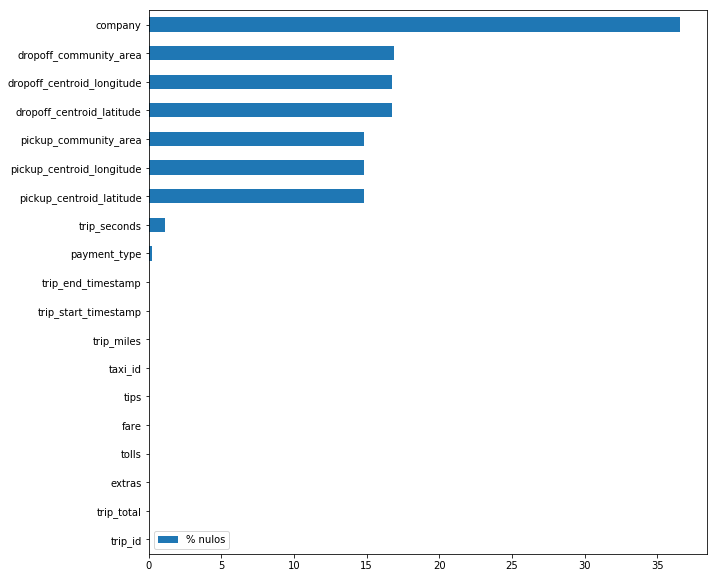

In [51]:
nulos_df.sort_values('% nulos').plot.barh(y='% nulos',figsize=(10,10))

### Study outliers

In [41]:
numeric_vars

['trip_seconds',
 'trip_miles',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude']

In [42]:
for num_var in numeric_vars:
    print(num_var)
    describe = taxi_df.select(F.round(F.mean(num_var), 2).alias("mean"),
                                F.min(num_var).alias("min"),
                                F.max(num_var).alias("max"),
                                F.round(F.stddev(num_var), 2).alias("stddv"))
    q1, median, q3 = taxi_df.approxQuantile(num_var, [0.25, 0.5, 0.75], 0)
    describe = describe.withColumn("q1", F.lit(q1))
    describe = describe.withColumn("median", F.lit(median))
    describe = describe.withColumn("q3", F.lit(q3))
    describe = describe.withColumn("iqr", F.lit(q3-q1))
    describe.show()

trip_seconds
+------+---+-----+-------+-----+------+-----+-----+
|  mean|min|  max|  stddv|   q1|median|   q3|  iqr|
+------+---+-----+-------+-----+------+-----+-----+
|748.14|  0|80400|1133.06|300.0| 540.0|900.0|600.0|
+------+---+-----+-------+-----+------+-----+-----+

trip_miles
+----+---+------+-----+---+------+---+---+
|mean|min|   max|stddv| q1|median| q3|iqr|
+----+---+------+-----+---+------+---+---+
|2.79|0.0|2210.0|13.85|0.0|   0.9|2.4|2.4|
+----+---+------+-----+---+------+---+---+

pickup_community_area
+-----+---+---+-----+---+------+----+----+
| mean|min|max|stddv| q1|median|  q3| iqr|
+-----+---+---+-----+---+------+----+----+
|22.37|  1| 77|19.39|8.0|  10.0|32.0|24.0|
+-----+---+---+-----+---+------+----+----+

dropoff_community_area
+-----+---+---+-----+---+------+----+----+
| mean|min|max|stddv| q1|median|  q3| iqr|
+-----+---+---+-----+---+------+----+----+
|21.18|  1| 77|17.77|8.0|  14.0|32.0|24.0|
+-----+---+---+-----+---+------+----+----+

fare
+-----+---+------

#### Delete the null values in the columns

In [21]:
taxi_df = taxi_df.dropna(how='any',
                         subset=['trip_id',
                                  'taxi_id',
                                  'trip_start_timestamp',
                                  'trip_end_timestamp',
                                  'trip_seconds',
                                  'trip_miles',
                                  'pickup_community_area',
                                  'dropoff_community_area',
                                  'fare',
                                  'tips',
                                  'tolls',
                                  'extras',
                                  'trip_total',
                                  'payment_type',
                                  'company',
                                  'pickup_centroid_latitude',
                                  'pickup_centroid_longitude',
                                  'dropoff_centroid_latitude',
                                  'dropoff_centroid_longitude'])

In [22]:
# Check the the reduce of trips because null values in the columns except 'company'
taxi_df.count()

60522966

In [24]:
# Check that all the nulls values are delete
n_rows = taxi_df.count()
for column in taxi_df.columns:
    n_nulls=taxi_df.filter(F.col(column).isNull()).count()
    perc_nulls = 100 * n_nulls / n_rows
    print(column, n_nulls, round(perc_nulls,2))

KeyboardInterrupt: 

### Eliminate the trips with wrong values like fare<=0, trip_total<=0, .... 

In [26]:
taxi_df = taxi_df.filter((F.col("trip_seconds") <= 0) |
                         (F.col("trip_miles") <= 0) |
                         (F.col("fare") <= 0) |
                         (F.col("tips") < 0) |
                         (F.col("tolls") < 0) |
                         (F.col("extras") < 0) |
                         (F.col("trip_total") <= 0))

In [28]:
taxi_df.count()

22792581

In [35]:
taxi_df.select(F.max('pickup_centroid_latitude'),F.min('pickup_centroid_latitude')).show()

KeyboardInterrupt: 

In [ ]:
taxi_df.select(F.max('dropoff_centroid_latitude'),F.min('dropoff_centroid_latitude')).show()

In [ ]:
taxi_df.select(F.max('pickup_centroid_longitude'),F.min('pickup_centroid_longitude')).show()

In [ ]:
taxi_df.select(F.max('dropoff_centroid_longitude'),F.min('dropoff_centroid_longitude')).show()

In [ ]:
taxi_df.groupBy("Pickup Community Area").count().sort('count',ascending=False).show(80)

In [ ]:
taxi_df.groupBy("Dropoff Community Area").count().sort('count',ascending=False).show(80)

In [52]:
taxi_df.describe(['Fare']).show()

+-------+------------------+
|summary|              Fare|
+-------+------------------+
|  count|            451680|
|   mean|12.825415515409153|
| stddev| 46.96985976074341|
|    min|               0.0|
|    max|           9000.42|
+-------+------------------+

